# **Advance Topics in Machine Learning**
## **Assignment 0 - Introduction**
---

### **Task 3: Understanding Generative Adversarial Network Dynamics**

In [1]:
# Cell 1: Setup (install if needed), imports, device, seed
# If running on Kaggle/Colab you can uncomment the pip lines.
# !pip -q install torchvision matplotlib numpy

import os, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# Cell 2: MNIST dataloaders (normalize to [-1, 1])
BATCH_SIZE = 64

tf = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    transforms.Normalize((0.5,), (0.5,)),    # -> [-1,1]
])

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=tf)
test_ds_full  = datasets.MNIST(root="./data", train=False, download=True, transform=tf)

train_loader = DataLoader(train_ds_full, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)
test_loader  = DataLoader(test_ds_full,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2)

print(len(train_ds_full), len(test_ds_full))


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:06<00:00, 1.57MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 113kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 658kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 410kB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

60000 10000


In [3]:
# Cell 3: Models — MLP Generator & Discriminator
# Generator: z(100) -> 256 -> 512 -> 784 -> tanh
class Generator(nn.Module):
    def __init__(self, z_dim=100, hidden=(256, 512)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim,      hidden[0]),
            nn.ReLU(True),
            nn.Linear(hidden[0],  hidden[1]),
            nn.ReLU(True),
            nn.Linear(hidden[1],  28*28),
            nn.Tanh(),  # output in [-1,1]
        )

    def forward(self, z):
        x = self.net(z)
        return x.view(z.size(0), 1, 28, 28)

# Discriminator: 784 -> 256 -> 256 -> 1 -> Sigmoid
class Discriminator(nn.Module):
    def __init__(self, hidden=(256, 256), dropout=0.0):
        super().__init__()
        layers = [
            nn.Linear(28*28, hidden[0]),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        if dropout > 0: layers.append(nn.Dropout(dropout))
        layers += [
            nn.Linear(hidden[0], hidden[1]),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        if dropout > 0: layers.append(nn.Dropout(dropout))
        layers += [
            nn.Linear(hidden[1], 1),
            nn.Sigmoid(),
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x).view(-1)


In [4]:
# Cell 4: Weight init, model factory, fixed noise, output dir
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def build_models(z_dim=100, d_dropout=0.0, g_hidden=(256,512), d_hidden=(256,256)):
    G = Generator(z_dim=z_dim, hidden=g_hidden).to(device)
    D = Discriminator(hidden=d_hidden, dropout=d_dropout).to(device)
    G.apply(weights_init_normal)
    D.apply(weights_init_normal)
    return G, D

os.makedirs("gan_outputs", exist_ok=True)
fixed_noise = torch.randn(25, 100, device=device)  # 5x5 grid


In [5]:
# Cell 5: Utils — save samples grid & plot losses
def save_samples(G, epoch, out_dir="gan_outputs", tag="baseline", nrow=5):
    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    # de-normalize from [-1,1] -> [0,1]
    grid = vutils.make_grid((fake + 1)/2, nrow=nrow, pad_value=1.0)
    path = os.path.join(out_dir, f"samples_{tag}_epoch_{epoch:03d}.png")
    vutils.save_image(grid, path)
    return path

def plot_losses(G_losses, D_losses, out_dir="gan_outputs", tag="baseline"):
    plt.figure()
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"GAN Losses ({tag})")
    plt.legend()
    path = os.path.join(out_dir, f"loss_{tag}.png")
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.close()
    return path


In [6]:
# Cell 6: Single training function with knobs for experiments
def train_gan(
    G, D, train_loader,
    epochs=20,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=False,         # one-sided smoothing for real labels (e.g., 0.9)
    non_saturating_G=True,      # use -log D(G(z)) instead of log(1 - D(G(z)))
    d_updates_per_g=1,          # D steps per G step
    g_updates_per_d=1,          # G steps per D step (rarely >1)
    tag="run",
    log_interval=200,
    out_dir="gan_outputs",
):
    G = G.to(device); D = D.to(device)
    G.train(); D.train()

    optG = torch.optim.Adam(G.parameters(), lr=lr_G, betas=betas)
    optD = torch.optim.Adam(D.parameters(), lr=lr_D, betas=betas)
    bce = nn.BCELoss()

    G_losses, D_losses = [], []
    step = 0

    for epoch in range(1, epochs+1):
        for real, _ in train_loader:
            real = real.to(device)
            bs   = real.size(0)

            # ------------------
            # 1) Update D (possibly multiple times)
            # ------------------
            for _ in range(d_updates_per_g):
                optD.zero_grad()

                # real
                real_labels = torch.full((bs,), 0.9 if label_smooth else 1.0, device=device)
                out_real = D(real)
                loss_real = bce(out_real, real_labels)

                # fake
                z = torch.randn(bs, z_dim, device=device)
                with torch.no_grad():
                    fake = G(z)
                fake_labels = torch.zeros(bs, device=device)
                out_fake = D(fake)
                loss_fake = bce(out_fake, fake_labels)

                loss_D = loss_real + loss_fake
                loss_D.backward()
                optD.step()

            # ------------------
            # 2) Update G (possibly multiple times)
            # ------------------
            for _ in range(g_updates_per_d):
                optG.zero_grad()
                z = torch.randn(bs, z_dim, device=device)
                fake = G(z)

                # D(G(z))
                out_fake = D(fake)

                if non_saturating_G:
                    # maximize log D(G(z)) <=> minimize -log D(G(z))
                    # target is 1 for fake to fool D
                    target = torch.ones(bs, device=device)
                    loss_G = bce(out_fake, target)
                else:
                    # original minimax: minimize log(1 - D(G(z)))
                    # numerical stability: use -(log(1 - D(G(z))))
                    # which is bce with target=0
                    target = torch.zeros(bs, device=device)
                    loss_G = bce(out_fake, target)

                loss_G.backward()
                optG.step()

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            if step % log_interval == 0:
                print(f"[{tag}] Epoch {epoch:02d} Step {step:05d} | D: {loss_D.item():.4f} | G: {loss_G.item():.4f}")
            step += 1

        # save fixed-noise samples per epoch
        img_path = save_samples(G, epoch, out_dir=out_dir, tag=tag)
        print(f"[{tag}] Saved samples:", img_path)

    loss_path = plot_losses(G_losses, D_losses, out_dir=out_dir, tag=tag)
    print(f"[{tag}] Saved loss plot:", loss_path)

    return {"G": G, "D": D, "G_losses": G_losses, "D_losses": D_losses}


In [7]:
# Cell 7: Baseline training run (20 epochs recommended; reduce if needed)
G_base, D_base = build_models(z_dim=100, d_dropout=0.0)
hist_base = train_gan(
    G_base, D_base, train_loader,
    epochs=20,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=False,
    non_saturating_G=True,
    d_updates_per_g=1,
    g_updates_per_d=1,
    tag="baseline",
    log_interval=200,
    out_dir="gan_outputs",
)


[baseline] Epoch 01 Step 00000 | D: 1.3842 | G: 0.6932
[baseline] Epoch 01 Step 00200 | D: 0.5026 | G: 1.2394
[baseline] Epoch 01 Step 00400 | D: 2.6864 | G: 0.4824
[baseline] Epoch 01 Step 00600 | D: 0.1914 | G: 2.3603
[baseline] Epoch 01 Step 00800 | D: 0.2168 | G: 3.7673
[baseline] Saved samples: gan_outputs\samples_baseline_epoch_001.png
[baseline] Epoch 02 Step 01000 | D: 0.3208 | G: 5.0258
[baseline] Epoch 02 Step 01200 | D: 0.2124 | G: 4.4152
[baseline] Epoch 02 Step 01400 | D: 0.2878 | G: 4.5710
[baseline] Epoch 02 Step 01600 | D: 0.3399 | G: 2.5757
[baseline] Epoch 02 Step 01800 | D: 0.5970 | G: 4.4404
[baseline] Saved samples: gan_outputs\samples_baseline_epoch_002.png
[baseline] Epoch 03 Step 02000 | D: 0.2800 | G: 3.4985
[baseline] Epoch 03 Step 02200 | D: 0.3880 | G: 1.8622
[baseline] Epoch 03 Step 02400 | D: 0.6319 | G: 2.9554
[baseline] Epoch 03 Step 02600 | D: 0.8071 | G: 1.2682
[baseline] Epoch 03 Step 02800 | D: 0.5533 | G: 4.8717
[baseline] Saved samples: gan_outputs

In [8]:
# Cell 8: Experiment — Gradient Vanishing scenario (strong D), then mitigation
# Scenario: make D much stronger early (higher LR + more D updates)
G_vanish, D_vanish = build_models(z_dim=100, d_dropout=0.0)
hist_vanish = train_gan(
    G_vanish, D_vanish, train_loader,
    epochs=10,
    z_dim=100,
    lr_G=2e-4, lr_D=1e-3,      # D LR 5x
    betas=(0.5, 0.999),
    label_smooth=False,         # no smoothing
    non_saturating_G=True,
    d_updates_per_g=5,          # train D 5x per G
    g_updates_per_d=1,
    tag="vanish_strongD",
    log_interval=200,
    out_dir="gan_outputs",
)

# Mitigation: add one-sided label smoothing and equalize training
G_vanish_fix, D_vanish_fix = build_models(z_dim=100, d_dropout=0.0)
hist_vanish_fix = train_gan(
    G_vanish_fix, D_vanish_fix, train_loader,
    epochs=10,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=True,          # smooth real labels to 0.9
    non_saturating_G=True,      # keep non-saturating
    d_updates_per_g=1,
    g_updates_per_d=1,
    tag="vanish_mitigated",
    log_interval=200,
    out_dir="gan_outputs",
)


[vanish_strongD] Epoch 01 Step 00000 | D: 0.7112 | G: 0.7004
[vanish_strongD] Epoch 01 Step 00200 | D: 0.0096 | G: 5.2455
[vanish_strongD] Epoch 01 Step 00400 | D: 0.0296 | G: 5.2499
[vanish_strongD] Epoch 01 Step 00600 | D: 0.0049 | G: 6.6978
[vanish_strongD] Epoch 01 Step 00800 | D: 0.0308 | G: 4.6487
[vanish_strongD] Saved samples: gan_outputs\samples_vanish_strongD_epoch_001.png
[vanish_strongD] Epoch 02 Step 01000 | D: 0.0055 | G: 7.1320
[vanish_strongD] Epoch 02 Step 01200 | D: 0.0644 | G: 4.2602
[vanish_strongD] Epoch 02 Step 01400 | D: 0.1103 | G: 3.9615
[vanish_strongD] Epoch 02 Step 01600 | D: 0.0348 | G: 7.1754
[vanish_strongD] Epoch 02 Step 01800 | D: 0.0510 | G: 4.2039
[vanish_strongD] Saved samples: gan_outputs\samples_vanish_strongD_epoch_002.png
[vanish_strongD] Epoch 03 Step 02000 | D: 0.0492 | G: 5.3807
[vanish_strongD] Epoch 03 Step 02200 | D: 0.0851 | G: 4.9444
[vanish_strongD] Epoch 03 Step 02400 | D: 0.0908 | G: 3.8397
[vanish_strongD] Epoch 03 Step 02600 | D: 0.0

In [9]:
# Cell 9: Experiment — Mode Collapse scenario (strong G), then mitigation
# Scenario: make G "too eager" (higher LR and more G steps)
G_collapse, D_collapse = build_models(z_dim=100, d_dropout=0.0)
hist_collapse = train_gan(
    G_collapse, D_collapse, train_loader,
    epochs=10,
    z_dim=100,
    lr_G=1e-3, lr_D=2e-4,     # G LR 5x
    betas=(0.5, 0.999),
    label_smooth=False,
    non_saturating_G=True,
    d_updates_per_g=1,
    g_updates_per_d=3,         # train G 3x per D
    tag="collapse_strongG",
    log_interval=200,
    out_dir="gan_outputs",
)

# Mitigation: strengthen D (more D steps) and/or reduce G LR
G_collapse_fix, D_collapse_fix = build_models(z_dim=100, d_dropout=0.0)
hist_collapse_fix = train_gan(
    G_collapse_fix, D_collapse_fix, train_loader,
    epochs=10,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=False,
    non_saturating_G=True,
    d_updates_per_g=2,          # train D more often
    g_updates_per_d=1,
    tag="collapse_mitigated",
    log_interval=200,
    out_dir="gan_outputs",
)


[collapse_strongG] Epoch 01 Step 00000 | D: 1.3815 | G: 0.6833
[collapse_strongG] Epoch 01 Step 00200 | D: 1.4217 | G: 0.6376
[collapse_strongG] Epoch 01 Step 00400 | D: 1.3936 | G: 0.6753
[collapse_strongG] Epoch 01 Step 00600 | D: 1.3859 | G: 0.7110
[collapse_strongG] Epoch 01 Step 00800 | D: 1.3866 | G: 0.7072
[collapse_strongG] Saved samples: gan_outputs\samples_collapse_strongG_epoch_001.png
[collapse_strongG] Epoch 02 Step 01000 | D: 1.3899 | G: 0.7026
[collapse_strongG] Epoch 02 Step 01200 | D: 1.3812 | G: 0.7166
[collapse_strongG] Epoch 02 Step 01400 | D: 1.3976 | G: 0.7024
[collapse_strongG] Epoch 02 Step 01600 | D: 0.1013 | G: 3.7303
[collapse_strongG] Epoch 02 Step 01800 | D: 0.0042 | G: 6.3030
[collapse_strongG] Saved samples: gan_outputs\samples_collapse_strongG_epoch_002.png
[collapse_strongG] Epoch 03 Step 02000 | D: 0.0011 | G: 7.7889
[collapse_strongG] Epoch 03 Step 02200 | D: 0.0005 | G: 8.3961
[collapse_strongG] Epoch 03 Step 02400 | D: 0.0003 | G: 8.7669
[collapse_s

In [10]:
# Cell 10: Experiment — Discriminator Overfitting scenario on limited data, then regularization
# Create a reduced dataset (e.g., first 1000 images). Optionally, even 200.
LIMIT = 1000
train_subset_idx = list(range(LIMIT))
train_loader_small = DataLoader(Subset(train_ds_full, train_subset_idx), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Overfit-prone D: zero dropout and slightly bigger model
G_overfit, D_overfit = build_models(z_dim=100, d_dropout=0.0, g_hidden=(256,512), d_hidden=(512,256))
hist_overfit = train_gan(
    G_overfit, D_overfit, train_loader_small,
    epochs=10,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=False,
    non_saturating_G=True,
    d_updates_per_g=1,
    g_updates_per_d=1,
    tag="overfit_smallset",
    log_interval=100,
    out_dir="gan_outputs",
)

# Mitigation: add dropout to D and mildly early-stop D by reducing its updates per G
G_overfit_fix, D_overfit_fix = build_models(z_dim=100, d_dropout=0.4, g_hidden=(256,512), d_hidden=(512,256))
hist_overfit_fix = train_gan(
    G_overfit_fix, D_overfit_fix, train_loader_small,
    epochs=10,
    z_dim=100,
    lr_G=2e-4, lr_D=2e-4,
    betas=(0.5, 0.999),
    label_smooth=True,          # also enable smoothing to keep D uncertain
    non_saturating_G=True,
    d_updates_per_g=1,          # keep balanced to avoid D fully converging each step
    g_updates_per_d=1,
    tag="overfit_mitigated",
    log_interval=100,
    out_dir="gan_outputs",
)


[overfit_smallset] Epoch 01 Step 00000 | D: 1.3854 | G: 0.6934
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_001.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_002.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_003.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_004.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_005.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_006.png
[overfit_smallset] Epoch 07 Step 00100 | D: 0.8717 | G: 0.8878
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_007.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_008.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_009.png
[overfit_smallset] Saved samples: gan_outputs\samples_overfit_smallset_epoch_010.png
[overfit_smallset] Saved

In [11]:
# Cell 11: Generate final 5x5 grids from each trained generator
paths = []
paths.append(save_samples(G_base,        epoch=0, out_dir="gan_outputs", tag="baseline_final"))
paths.append(save_samples(G_vanish,      epoch=0, out_dir="gan_outputs", tag="vanish_strongD_final"))
paths.append(save_samples(G_vanish_fix,  epoch=0, out_dir="gan_outputs", tag="vanish_mitigated_final"))
paths.append(save_samples(G_collapse,    epoch=0, out_dir="gan_outputs", tag="collapse_strongG_final"))
paths.append(save_samples(G_collapse_fix,epoch=0, out_dir="gan_outputs", tag="collapse_mitigated_final"))
paths.append(save_samples(G_overfit,     epoch=0, out_dir="gan_outputs", tag="overfit_smallset_final"))
paths.append(save_samples(G_overfit_fix, epoch=0, out_dir="gan_outputs", tag="overfit_mitigated_final"))

paths


['gan_outputs\\samples_baseline_final_epoch_000.png',
 'gan_outputs\\samples_vanish_strongD_final_epoch_000.png',
 'gan_outputs\\samples_vanish_mitigated_final_epoch_000.png',
 'gan_outputs\\samples_collapse_strongG_final_epoch_000.png',
 'gan_outputs\\samples_collapse_mitigated_final_epoch_000.png',
 'gan_outputs\\samples_overfit_smallset_final_epoch_000.png',
 'gan_outputs\\samples_overfit_mitigated_final_epoch_000.png']

gan_outputs\samples_collapse_strongG_final_epoch_000.png


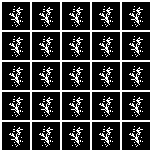

gan_outputs\samples_collapse_mitigated_final_epoch_000.png


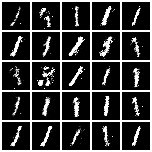

gan_outputs\samples_overfit_smallset_final_epoch_000.png


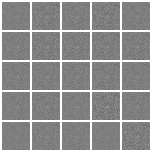

gan_outputs\samples_overfit_mitigated_final_epoch_000.png


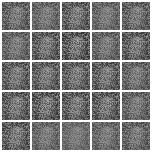

In [12]:
# Cell 12: (Optional) Quick visual display inline for the most recent run
from IPython.display import Image as IPyImage, display as ipy_display
for p in paths[-4:]:
    print(p)
    ipy_display(IPyImage(filename=p))
